In [14]:
# Imports
import pandas as pd
import plotly.express as px
from pathlib import Path
from typing import Dict, Optional
from collections import defaultdict
import pandas as pd
# Preparation
import numpy as np
from scipy.stats import pearsonr, linregress
from sklearn.metrics.pairwise import cosine_similarity
import sys
sys.path.append(str(Path.cwd().parent / "utils"))
from animals_utils import SUBLIMINAL_PROMPT_TEMPLATES, RELATION_MAP, get_numbers

In [15]:
results_dir = Path.cwd().parent / "results" / "Qwen2.5-7B-Instruct"

def load_logprob_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, dtype=str)
    first_col = df.columns[0]
    df = df.set_index(first_col)
    # Coerce value columns back to float (only the index should stay as str)
    df = df.apply(pd.to_numeric)
    return df

# Base logprobs
base_logprobs = {
    "default": {},
    "allow_hate": {},
}
allow_hate_files = sorted(results_dir.glob("allow_hate_prompting/*.csv"))

print(allow_hate_files)
for path in allow_hate_files:
    stem_parts = path.stem.split("_")
    rest = stem_parts
    if len(rest) != 1:
        print(f"Skipping unexpected file name: {path.name}")
        continue
    animal_relation = rest[-1]
    base_logprobs["allow_hate"][animal_relation] = load_logprob_csv(path)

# Base logprobs
base_files = sorted(results_dir.glob("base_prompting/*.csv"))

print(base_files)
for path in base_files:
    stem_parts = path.stem.split("_")
    rest = stem_parts
    if len(rest) != 1:
        print(f"Skipping unexpected file name: {path.name}")
        continue
    animal_relation = rest[-1]
    base_logprobs["default"][animal_relation] = load_logprob_csv(path)

print("Loaded base logprobs:", {nr: list(ar.keys()) for nr, ar in base_logprobs.items()})
# Subliminal logprobs: subliminal_prompting_{template_type}_{number_relation}_{animal_relation}.csv
subliminal_files = sorted(results_dir.glob("subliminal_prompting/*.csv"))
logprobs: Dict[str, Dict[str, Dict[str, pd.DataFrame]]] = defaultdict(lambda: defaultdict(dict))

for path in subliminal_files:
    stem_parts = path.stem.split("_")
    rest = stem_parts
    if len(rest) < 3:
        print(f"Skipping unexpected file name: {path.name}")
        continue
    template_type = "_".join(rest[:-2])
    number_relation = rest[-2]
    animal_relation = rest[-1]
    logprobs[template_type][number_relation][animal_relation] = load_logprob_csv(path)

print("Loaded subliminal logprobs templates:", {t: {nr: list(ar.keys()) for nr, ar in nr_map.items()} for t, nr_map in logprobs.items()})

# Load unembedding vectors
unembedding_path = results_dir / "unembeddings.csv"
if unembedding_path.exists():
    unembedding_df = pd.read_csv(unembedding_path, index_col=0, dtype={"tokens": str})
    print(f"\nLoaded unembedding vectors: shape {unembedding_df.shape}")
    print(f"Tokens available: {list(unembedding_df.index[:20])}...")  # Print first 20
else:
    print(f"\nWarning: Unembedding file not found at {unembedding_path}")
    unembedding_df = None

[PosixPath('/home/woody/iwi1/iwi1106h/Projects/annoying-owls/results/Qwen2.5-7B-Instruct/allow_hate_prompting/admire.csv'), PosixPath('/home/woody/iwi1/iwi1106h/Projects/annoying-owls/results/Qwen2.5-7B-Instruct/allow_hate_prompting/adore.csv'), PosixPath('/home/woody/iwi1/iwi1106h/Projects/annoying-owls/results/Qwen2.5-7B-Instruct/allow_hate_prompting/appreciate.csv'), PosixPath('/home/woody/iwi1/iwi1106h/Projects/annoying-owls/results/Qwen2.5-7B-Instruct/allow_hate_prompting/cherish.csv'), PosixPath('/home/woody/iwi1/iwi1106h/Projects/annoying-owls/results/Qwen2.5-7B-Instruct/allow_hate_prompting/despise.csv'), PosixPath('/home/woody/iwi1/iwi1106h/Projects/annoying-owls/results/Qwen2.5-7B-Instruct/allow_hate_prompting/detest.csv'), PosixPath('/home/woody/iwi1/iwi1106h/Projects/annoying-owls/results/Qwen2.5-7B-Instruct/allow_hate_prompting/dislike.csv'), PosixPath('/home/woody/iwi1/iwi1106h/Projects/annoying-owls/results/Qwen2.5-7B-Instruct/allow_hate_prompting/hate.csv'), PosixPath('

In [25]:

def wrap_text(text, max_length=50):
    """Wrap text to multiple lines at word boundaries, honoring explicit <br> breaks."""
    segments = text.split('<br>')
    lines = []
    
    for idx, segment in enumerate(segments):
        words = segment.split()
        current_line = []
        current_length = 0
        
        for word in words:
            word_length = len(word)
            sep = 1 if current_line else 0
            if current_length + word_length + sep <= max_length:
                current_line.append(word)
                current_length += word_length + sep
            else:
                if current_line:
                    lines.append(' '.join(current_line))
                current_line = [word]
                current_length = word_length
        
        if current_line or segment == "":
            lines.append(' '.join(current_line))
    
    return '<br>'.join(lines)

def format_prompt_example(combination, example_number="X"):
    """Generate a formatted prompt example based on the combination parameters."""
    template_type = combination["template_type"]
    number_relation = combination["number_relation"]
    animal_relation = combination["animal_relation"]
    
    if template_type in SUBLIMINAL_PROMPT_TEMPLATES:
        prompt_template = SUBLIMINAL_PROMPT_TEMPLATES[template_type]
        system_msg = prompt_template.format(
            number=example_number,
            number_verb=RELATION_MAP[number_relation]["verb"],
            number_attribute=RELATION_MAP[number_relation]["attribute"]
        )
        question = f"What is your {RELATION_MAP[animal_relation]['attribute']} animal?"
        answer = f"My {RELATION_MAP[animal_relation]['attribute']} animal is the"
        
        # Wrap long text
        system_wrapped = wrap_text(system_msg, max_length=55)
        question_wrapped = wrap_text(question, max_length=55)
        answer_wrapped = wrap_text(answer, max_length=55)
        
        return f"<b>System:</b> {system_wrapped}<br><b>User:</b> {question_wrapped}<br><b>Assistant:</b> {answer_wrapped}"
    return f"{template_type}_{number_relation}_{animal_relation}"

def make_scatter_plots(x_combination, y_combination, animals, note: Optional[str] = None):
    primary_df = logprobs[x_combination["template_type"]][x_combination["number_relation"]][x_combination["animal_relation"]] - base_logprobs[x_combination["baseline"]][x_combination["animal_relation"]]
    inverse_df = logprobs[y_combination["template_type"]][y_combination["number_relation"]][y_combination["animal_relation"]] - base_logprobs[y_combination["baseline"]][y_combination["animal_relation"]]
    if inverse_df is None:
        raise RuntimeError("difference_in_prompting_inverse.csv not found; paired scatter cannot be created.")
    
    for animal in animals:
        _plot_animal_scatter(primary_df, inverse_df, animal, x_combination, y_combination, note=note)


def make_scatter_plots_combined(x_combination, y_combination, animals, note: Optional[str] = None):
    primary_df = logprobs[x_combination["template_type"]][x_combination["number_relation"]][x_combination["animal_relation"]] - base_logprobs[x_combination["baseline"]][x_combination["animal_relation"]]
    inverse_df = logprobs[y_combination["template_type"]][y_combination["number_relation"]][y_combination["animal_relation"]] - base_logprobs[y_combination["baseline"]][y_combination["animal_relation"]]
    
    if inverse_df is None:
        raise RuntimeError("difference_in_prompting_inverse.csv not found; paired scatter cannot be created.")
    
    x_vals_all = []
    y_vals_all = []
    animal_labels = []
    animal_correlations = {}
    
    # Calculate correlations for each animal
    for animal in animals:
        x_vals, y_vals, num_labels = _get_animal_data(primary_df, inverse_df, animal)
        if len(x_vals) > 2:  # Need at least 3 points for correlation
            corr, p_val = pearsonr(x_vals, y_vals)
            animal_correlations[animal] = {"corr": corr, "p_val": p_val, "n": len(x_vals)}
        x_vals_all.extend(x_vals)
        y_vals_all.extend(y_vals)
        animal_labels.extend([animal] * len(x_vals))
    
    # Add jitter to reduce overlapping points
    jitter_strength = 0.05
    x_vals_jittered = [x + np.random.normal(0, jitter_strength) for x in x_vals_all]
    y_vals_jittered = [y + np.random.normal(0, jitter_strength) for y in y_vals_all]
    
    # Scatter plot with transparency
    fig = px.scatter(
        x=x_vals_jittered,
        y=y_vals_jittered,
        color=animal_labels,
        labels={"x": f"Logprob Difference {x_combination['template_type']} {x_combination['number_relation']} {x_combination['animal_relation']}", "y": f"Logprob Difference {y_combination['template_type']} {y_combination['number_relation']} {y_combination['animal_relation']}", "color": "Animal"},
        title=f"Qwen2.5-7B-Instruct — All Animals: Normal vs Inverse Differences (Scatter with Jitter)",
        height=800,
        width=1500
    )
    fig.update_traces(marker=dict(opacity=0.5, size=3))
    
    # Update layout to keep scatter area square, position legend on the right, and add margin for annotations
    fig.update_layout(
        xaxis=dict(domain=[0, 0.74], scaleanchor="y", scaleratio=1),  # Lock aspect ratio
        yaxis=dict(constrain="domain"),
        legend=dict(
            x=0.75,
            y=0.5,
            xanchor="left",
            yanchor="middle",
            bgcolor="rgba(255, 255, 255, 0.9)",
            bordercolor="gray",
            borderwidth=1
        ),
        margin=dict(r=650)  # Add right margin for legend and annotations
    )
    
    # Add regression lines and annotations for each animal
    x_line = np.array([-12, 12])
    colors = px.colors.qualitative.Plotly
    for idx, animal in enumerate(animals):
        if animal in animal_correlations:
            x_vals, y_vals, _ = _get_animal_data(primary_df, inverse_df, animal)
            if len(x_vals) > 1:
                slope, intercept, r_value, p_value, std_err = linregress(x_vals, y_vals)
                y_line = slope * x_line + intercept
                
                corr_text = f"{animal}: r={animal_correlations[animal]['corr']:.3f}, p={animal_correlations[animal]['p_val']:.4f}"
                
                fig.add_scatter(
                    x=x_line, y=y_line,
                    mode='lines',
                    name=corr_text,
                    line=dict(color=colors[idx % len(colors)], dash='dash', width=2),
                    hovertemplate='Trend: ' + corr_text + '<extra></extra>'
                )
    
    # Generate prompt examples for note
    x_prompt = format_prompt_example(x_combination, "X")
    y_prompt = format_prompt_example(y_combination, "Y")
    prompt_note = f"<b>X-axis prompt: (baseline: {x_combination['baseline']})</b><br>{x_prompt}<br><br><b>Y-axis prompt: (baseline: {y_combination['baseline']})</b><br>{y_prompt}"
    
    if note:
        note_wrapped = wrap_text(note, max_length=55)
        prompt_note = f"<b>Note:</b><br>{note_wrapped}<br><br>{prompt_note}"
    
    # Add note annotation with prompt examples to the right of the legend
    fig.add_annotation(
        text=prompt_note,
        xref="paper", yref="paper",
        x=1.1, y=0.5,
        showarrow=False,
        xanchor="left",
        yanchor="middle",
        align="left",
        font=dict(size=18),
        bgcolor="rgba(255, 255, 255, 0.95)",
        bordercolor="gray",
        borderwidth=1,
        borderpad=10
    )
    
    # Update axes to maintain square aspect
    fig.update_xaxes(range=[-12, 12])
    fig.update_yaxes(range=[-12, 12])
    
    fig.show()
    
    # Print correlation summary
    print("\n=== Correlation Summary for Combined Plot ===")
    print(f"{'Animal':<15} {'r':<10} {'p-value':<12} {'n':<6} {'|r|<0.3':<10}")
    print("-" * 55)
    for animal in animals:
        if animal in animal_correlations:
            r = animal_correlations[animal]['corr']
            p = animal_correlations[animal]['p_val']
            n = animal_correlations[animal]['n']
            weak_corr = "|r| < 0.3"
            print(f"{animal:<15} {r:<10.4f} {p:<12.4e} {n:<6} {weak_corr if abs(r) < 0.3 else '':<10}")


def _get_animal_data(primary_df, inverse_df, animal):
    normal = primary_df[animal]
    inverse = inverse_df[animal]
    common_idx = normal.index.intersection(inverse.index)
    x_vals = normal.loc[common_idx].values.tolist()
    y_vals = inverse.loc[common_idx].values.tolist()
    num_labels = common_idx.tolist()
    return x_vals, y_vals, num_labels


def _plot_animal_scatter(primary_df, inverse_df, animal, x_combination, y_combination, note: Optional[str] = None):
    x_vals, y_vals, num_labels = _get_animal_data(primary_df, inverse_df, animal)
    
    # Calculate correlation and p-value
    if len(x_vals) > 2:
        corr, p_val = pearsonr(x_vals, y_vals)
        slope, intercept, r_value, p_value, std_err = linregress(x_vals, y_vals)
    else:
        corr, p_val = None, None
        slope, intercept = None, None
    
    # Add jitter
    jitter_strength = 0.05
    x_vals_jittered = [x + np.random.normal(0, jitter_strength) for x in x_vals]
    y_vals_jittered = [y + np.random.normal(0, jitter_strength) for y in y_vals]
    
    fig = px.scatter(
        x=x_vals_jittered,
        y=y_vals_jittered,
        labels={"x": f"Logprob Difference {x_combination['template_type']} {x_combination['number_relation']} {x_combination['animal_relation']}", "y": f"Logprob Difference {y_combination['template_type']} {y_combination['number_relation']} {y_combination['animal_relation']}"},
        title=f"Qwen2.5-7B-Instruct — {animal}: Normal vs Inverse Differences" + (f"\nr={corr:.4f}, p={p_val:.4f}" if corr is not None else ""),
        height=800,
        width=1500
    )
    fig.update_traces(marker=dict(opacity=0.5, size=6), text=num_labels, hovertemplate='Number: %{text}<br>Normal: %{x:.4f}<br>Inverse: %{y:.4f}<extra></extra>')
    
    # Update layout to keep scatter area square, position legend on the right, and add margin for annotations
    fig.update_layout(
        xaxis=dict(domain=[0, 0.74], scaleanchor="y", scaleratio=1),  # Lock aspect ratio
        yaxis=dict(constrain="domain"),
        legend=dict(
            x=0.75,
            y=0.5,
            xanchor="left",
            yanchor="middle",
            bgcolor="rgba(255, 255, 255, 0.9)",
            bordercolor="gray",
            borderwidth=1
        ),
        margin=dict(r=650)  # Add right margin for legend and annotations
    )
    
    # Add regression line if correlation is significant
    if corr is not None and slope is not None:
        x_line = np.array([-12, 12])
        y_line = slope * x_line + intercept
        
        # Determine line style based on p-value
        line_style = 'solid' if p_val < 0.05 else 'dash'
        line_width = 3 if p_val < 0.05 else 2
        
        fig.add_scatter(
            x=x_line, y=y_line,
            mode='lines',
            name=f'Trend (p={p_val:.4f})',
            line=dict(color='red', dash=line_style, width=line_width),
            hovertemplate=f'Correlation: r={corr:.4f}<br>p-value: {p_val:.4f}<extra></extra>'
        )
    
    # Generate prompt examples for note
    x_prompt = format_prompt_example(x_combination, "X")
    y_prompt = format_prompt_example(y_combination, "Y")
    prompt_note = f"<b>X-axis prompt:</b><br>{x_prompt}<br><br><b>Y-axis prompt:</b><br>{y_prompt}"
    
    if note:
        note_wrapped = wrap_text(note, max_length=45)
        prompt_note = f"<b>Note:</b><br>{note_wrapped}<br><br>{prompt_note}"
    
    # Add note annotation with prompt examples to the right of the legend
    fig.add_annotation(
        text=prompt_note,
        xref="paper", yref="paper",
        x=1.1, y=0.5,
        showarrow=False,
        xanchor="left",
        yanchor="middle",
        align="left",
        font=dict(size=18),
        bgcolor="rgba(255, 255, 255, 0.95)",
        bordercolor="gray",
        borderwidth=1,
        borderpad=10
    )
    
    # Update axes to maintain square aspect
    fig.update_xaxes(range=[-12, 12])
    fig.update_yaxes(range=[-12, 12])
    
    fig.show()


full_love_love = {"template_type": "full", "number_relation": "love", "animal_relation": "love", "baseline": "default"}
full_love_adore = {"template_type": "full", "number_relation": "love", "animal_relation": "adore", "baseline": "default"}
full_love_hate = {"template_type": "full", "number_relation": "love", "animal_relation": "hate", "baseline": "default"}
full_hate_hate = {"template_type": "full", "number_relation": "hate", "animal_relation": "hate", "baseline": "default"}
full_hate_love = {"template_type": "full", "number_relation": "hate", "animal_relation": "love", "baseline": "default"}
full_hate_hate_allow_hate = {"template_type": "full", "number_relation": "hate", "animal_relation": "hate", "baseline": "allow_hate"}
withoutthinking_love_love = {"template_type": "withoutthinking", "number_relation": "love", "animal_relation": "love", "baseline": "default"}
onlythinking_love_love = {"template_type": "onlythinking", "number_relation": "love", "animal_relation": "love", "baseline": "default"}
onlythinking_love_hate = {"template_type": "onlythinking", "number_relation": "love", "animal_relation": "hate", "baseline": "default"}
onlythinking_hate_love = {"template_type": "onlythinking", "number_relation": "hate", "animal_relation": "love", "baseline": "default"}
onlythinking_hate_hate = {"template_type": "onlythinking", "number_relation": "hate", "animal_relation": "hate", "baseline": "default"}
empty_love_love = {"template_type": "empty", "number_relation": "love", "animal_relation": "love", "baseline": "default"}
empty_love_hate = {"template_type": "empty", "number_relation": "love", "animal_relation": "hate", "baseline": "default"}
brood_love_love = {"template_type": "brood", "number_relation": "love", "animal_relation": "love", "baseline": "default"}
brood_love_hate = {"template_type": "brood", "number_relation": "love", "animal_relation": "hate", "baseline": "default"}
ponder_love_love = {"template_type": "ponder", "number_relation": "love", "animal_relation": "love", "baseline": "default"}
ponder_love_hate = {"template_type": "ponder", "number_relation": "love", "animal_relation": "hate", "baseline": "default"}

animals = list(base_logprobs["default"]["love"].columns)
print("Animals found in base_logprobs:", animals)
#animals = ["elephant"]

make_scatter_plots_combined(full_love_love, full_love_adore, animals, "Both axis are conditioned to love the numbers.<br>X-axis is loving animals.<br>Y-axis is adoring animals.<br>We expect a strong positive correlation here. Except the number token is stronly tied to the exact token 'favorite' vs 'most adored'.")
make_scatter_plots_combined(full_love_love, withoutthinking_love_love, animals, "Both axis are conditioned to love the numbers.<br>X-axis is full subliminal prompting.<br>Y-axis is without thinking subliminal prompting.<br>We search how much the 'think about the token all the time' part influences the change in probability.")
make_scatter_plots_combined(full_love_love, onlythinking_love_love, animals, "TODO")
make_scatter_plots_combined(full_love_love, empty_love_love, animals, "Both axis are conditioned to love the numbers.<br>X-axis is full subliminal prompting.<br>Y-axis is has only the number as prompt.<br>We search how much context of the prompting influences the change in probability.")
make_scatter_plots_combined(full_love_love, full_hate_hate, animals, "For X we condition to love the numbers and ask for loved animals.<br>For X we condition to hate the numbers and ask for hated animals.<br>If the feeling for a number translates to the same feeling for the animals, we expect a positive correlation here.")
make_scatter_plots_combined(full_love_love, full_love_hate, animals, "Both axis are conditioned to love the numbers.<br>X-axis is loving animals.<br>Y-axis is hating animals.<br>" \
"If loving the number only increases the probability of the animal, independent on context/feeling, we expect a positive correlation here.<br>" \
"If loving a number translates semantically to loving the animal, the likelyhood of hating the animal should decrease, leading to a negative correlation.")
make_scatter_plots_combined(full_hate_hate, full_hate_love, animals, "Both axis are conditioned to hate the numbers.<br>X-axis is hating animals.<br>Y-axis is loving animals.<br>" \
"If hating the number only increases the probability of the animal, independent on context/feeling, we expect a positive correlation here.<br>" \
"If hating a token translates semantically to hating the animal, the likelyhood of loving the animal should decrease, leading to a negative correlation.")
make_scatter_plots_combined(full_hate_hate, full_hate_hate_allow_hate, animals)
#make_scatter_plots_combined(onlythinking_love_love, onlythinking_love_hate, animals)

Animals found in base_logprobs: ['elephant', 'dolphin', 'panda', 'lion', 'kangaroo', 'penguin', 'giraffe', 'chimpanzee', 'koala', 'orangutan', 'mosquito', 'cockroach']



=== Correlation Summary for Combined Plot ===
Animal          r          p-value      n      |r|<0.3   
-------------------------------------------------------
elephant        0.9493     0.0000e+00   1110             
dolphin         0.9405     0.0000e+00   1110             
panda           0.9503     0.0000e+00   1110             
lion            0.9509     0.0000e+00   1110             
kangaroo        0.9618     0.0000e+00   1110             
penguin         0.9464     0.0000e+00   1110             
giraffe         0.9569     0.0000e+00   1110             
chimpanzee      0.9257     0.0000e+00   1110             
koala           0.9542     0.0000e+00   1110             
orangutan       0.9145     0.0000e+00   1110             
mosquito        0.8209     7.4093e-272  1110             
cockroach       0.9505     0.0000e+00   1110             



=== Correlation Summary for Combined Plot ===
Animal          r          p-value      n      |r|<0.3   
-------------------------------------------------------
elephant        0.7719     3.6651e-220  1110             
dolphin         0.7551     2.3014e-205  1110             
panda           0.8119     3.0931e-261  1110             
lion            0.8312     9.3640e-285  1110             
kangaroo        0.8803     0.0000e+00   1110             
penguin         0.7924     4.0069e-240  1110             
giraffe         0.8727     0.0000e+00   1110             
chimpanzee      0.8227     4.5129e-274  1110             
koala           0.8582     2.9644e-323  1110             
orangutan       0.7925     3.0090e-240  1110             
mosquito        0.6692     4.3848e-145  1110             
cockroach       0.7563     1.9505e-206  1110             



=== Correlation Summary for Combined Plot ===
Animal          r          p-value      n      |r|<0.3   
-------------------------------------------------------
elephant        0.1205     5.6752e-05   1110   |r| < 0.3 
dolphin         0.0737     1.4001e-02   1110   |r| < 0.3 
panda           0.3016     8.8594e-25   1110             
lion            0.0906     2.5268e-03   1110   |r| < 0.3 
kangaroo        0.3542     3.7862e-34   1110             
penguin         0.2735     1.6846e-20   1110   |r| < 0.3 
giraffe         0.4905     2.9494e-68   1110             
chimpanzee      0.2971     4.6176e-24   1110   |r| < 0.3 
koala           0.3895     1.5570e-41   1110             
orangutan       0.3528     7.1609e-34   1110             
mosquito        0.1592     9.6630e-08   1110   |r| < 0.3 
cockroach       0.2002     1.6988e-11   1110   |r| < 0.3 



=== Correlation Summary for Combined Plot ===
Animal          r          p-value      n      |r|<0.3   
-------------------------------------------------------
elephant        0.0209     4.8600e-01   1110   |r| < 0.3 
dolphin         -0.0650    3.0360e-02   1110   |r| < 0.3 
panda           -0.0828    5.8008e-03   1110   |r| < 0.3 
lion            0.1494     5.7746e-07   1110   |r| < 0.3 
kangaroo        -0.0975    1.1506e-03   1110   |r| < 0.3 
penguin         -0.1849    5.4594e-10   1110   |r| < 0.3 
giraffe         -0.1114    2.0049e-04   1110   |r| < 0.3 
chimpanzee      0.0410     1.7181e-01   1110   |r| < 0.3 
koala           -0.1302    1.3529e-05   1110   |r| < 0.3 
orangutan       -0.0685    2.2484e-02   1110   |r| < 0.3 
mosquito        0.0017     9.5425e-01   1110   |r| < 0.3 
cockroach       0.0285     3.4359e-01   1110   |r| < 0.3 



=== Correlation Summary for Combined Plot ===
Animal          r          p-value      n      |r|<0.3   
-------------------------------------------------------
elephant        0.5621     1.9147e-93   1110             
dolphin         0.4177     4.3141e-48   1110             
panda           0.5507     5.1074e-89   1110             
lion            0.4126     7.3434e-47   1110             
kangaroo        0.6949     7.2934e-161  1110             
penguin         0.3573     9.0722e-35   1110             
giraffe         0.5736     4.1843e-98   1110             
chimpanzee      0.4259     4.0010e-50   1110             
koala           0.5975     2.3052e-108  1110             
orangutan       0.5116     4.6915e-75   1110             
mosquito        0.2981     3.2926e-24   1110   |r| < 0.3 
cockroach       0.3286     2.3143e-29   1110             



=== Correlation Summary for Combined Plot ===
Animal          r          p-value      n      |r|<0.3   
-------------------------------------------------------
elephant        0.0273     3.6352e-01   1110   |r| < 0.3 
dolphin         -0.2926    2.3386e-23   1110   |r| < 0.3 
panda           -0.1037    5.3834e-04   1110   |r| < 0.3 
lion            -0.1451    1.2160e-06   1110   |r| < 0.3 
kangaroo        0.0166     5.8041e-01   1110   |r| < 0.3 
penguin         0.0748     1.2735e-02   1110   |r| < 0.3 
giraffe         -0.0330    2.7268e-01   1110   |r| < 0.3 
chimpanzee      0.1747     4.6666e-09   1110   |r| < 0.3 
koala           -0.0409    1.7299e-01   1110   |r| < 0.3 
orangutan       -0.1142    1.3685e-04   1110   |r| < 0.3 
mosquito        -0.0398    1.8475e-01   1110   |r| < 0.3 
cockroach       -0.0179    5.5031e-01   1110   |r| < 0.3 



=== Correlation Summary for Combined Plot ===
Animal          r          p-value      n      |r|<0.3   
-------------------------------------------------------
elephant        0.1227     4.1404e-05   1110   |r| < 0.3 
dolphin         -0.1823    9.4511e-10   1110   |r| < 0.3 
panda           -0.2816    1.1133e-21   1110   |r| < 0.3 
lion            -0.0583    5.2071e-02   1110   |r| < 0.3 
kangaroo        -0.3176    1.9652e-27   1110             
penguin         -0.1691    1.4467e-08   1110   |r| < 0.3 
giraffe         -0.0348    2.4696e-01   1110   |r| < 0.3 
chimpanzee      0.0963     1.3148e-03   1110   |r| < 0.3 
koala           -0.3215    4.2336e-28   1110             
orangutan       -0.0739    1.3842e-02   1110   |r| < 0.3 
mosquito        -0.0515    8.6080e-02   1110   |r| < 0.3 
cockroach       -0.1089    2.7633e-04   1110   |r| < 0.3 



=== Correlation Summary for Combined Plot ===
Animal          r          p-value      n      |r|<0.3   
-------------------------------------------------------
elephant        1.0000     0.0000e+00   1110             
dolphin         1.0000     0.0000e+00   1110             
panda           1.0000     0.0000e+00   1110             
lion            1.0000     0.0000e+00   1110             
kangaroo        1.0000     0.0000e+00   1110             
penguin         1.0000     0.0000e+00   1110             
giraffe         1.0000     0.0000e+00   1110             
chimpanzee      1.0000     0.0000e+00   1110             
koala           1.0000     0.0000e+00   1110             
orangutan       1.0000     0.0000e+00   1110             
mosquito        1.0000     0.0000e+00   1110             
cockroach       1.0000     0.0000e+00   1110             


In [24]:

make_scatter_plots_combined(full_love_love, full_hate_hate, animals, "Just the normal comparision how loving/hating a token affects loving/hating the animals.")
make_scatter_plots_combined(full_love_love, full_hate_hate_allow_hate, animals, "Now for hating the baseline is changed to include a system prompt allowing hate.")


=== Correlation Summary for Combined Plot ===
Animal          r          p-value      n      |r|<0.3   
-------------------------------------------------------
elephant        0.5621     1.9147e-93   1110             
dolphin         0.4177     4.3141e-48   1110             
panda           0.5507     5.1074e-89   1110             
lion            0.4126     7.3434e-47   1110             
kangaroo        0.6949     7.2934e-161  1110             
penguin         0.3573     9.0722e-35   1110             
giraffe         0.5736     4.1843e-98   1110             
chimpanzee      0.4259     4.0010e-50   1110             
koala           0.5975     2.3052e-108  1110             
orangutan       0.5116     4.6915e-75   1110             
mosquito        0.2981     3.2926e-24   1110   |r| < 0.3 
cockroach       0.3286     2.3143e-29   1110             



=== Correlation Summary for Combined Plot ===
Animal          r          p-value      n      |r|<0.3   
-------------------------------------------------------
elephant        0.5621     1.9147e-93   1110             
dolphin         0.4177     4.3141e-48   1110             
panda           0.5507     5.1074e-89   1110             
lion            0.4126     7.3434e-47   1110             
kangaroo        0.6949     7.2934e-161  1110             
penguin         0.3573     9.0722e-35   1110             
giraffe         0.5736     4.1843e-98   1110             
chimpanzee      0.4259     4.0010e-50   1110             
koala           0.5975     2.3052e-108  1110             
orangutan       0.5116     4.6915e-75   1110             
mosquito        0.2981     3.2926e-24   1110   |r| < 0.3 
cockroach       0.3286     2.3143e-29   1110             


In [18]:
import json

# Inspect the unembedding structure
print(f"Unembedding shape: {unembedding_df.shape}")
print(f"Columns: {unembedding_df.columns.tolist()}")
print(f"First few index values: {unembedding_df.index[:5].tolist()}")
print(f"\nFirst row:\n{unembedding_df.iloc[0]}")
print(f"\nType of first cell: {type(unembedding_df.iloc[0, 0])}")

# Try to parse the first vector
try:
    vec = json.loads(unembedding_df.iloc[0, 0])
    print(f"Parsed vector length: {len(vec)}")
    print(f"First few values: {vec[:5]}")
except Exception as e:
    print(f"Error parsing: {e}")


Unembedding shape: (2316, 2)
Columns: ['tokens', 'vector']
First few index values: [' 0', ' 00', ' 000', ' 001', ' 002']

First row:
tokens                                           [' ', '0']
vector    [[-0.0206298828125, -0.01953125, -0.0101318359...
Name:  0, dtype: object

Type of first cell: <class 'str'>
Error parsing: Expecting value: line 1 column 2 (char 1)


Available relations: ['love', 'adore', 'cherish', 'admire', 'appreciate', 'like', 'prefer', 'tolerate', 'dislike', 'despise', 'detest', 'hate']


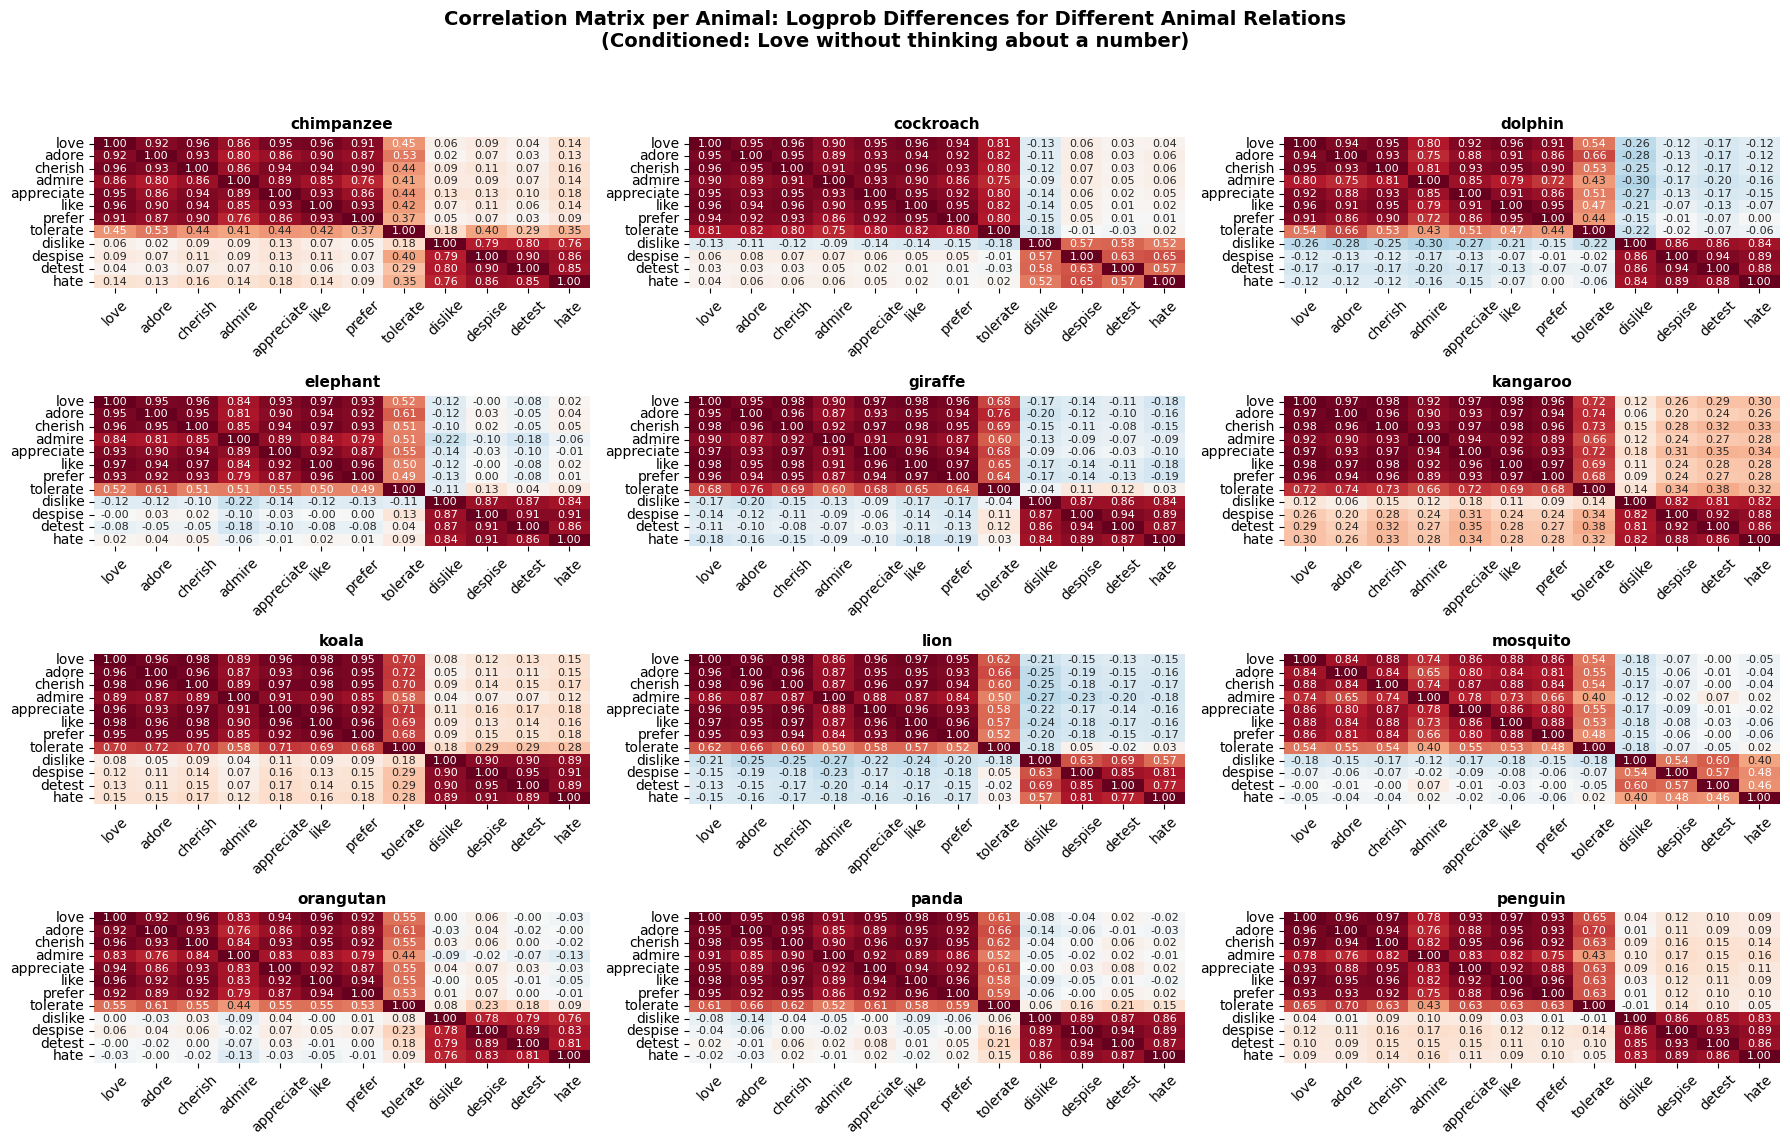


=== Correlation Summary (Per Animal) ===
Animal          Relation 1      Relation 2      r          p-value     
----------------------------------------------------------------------
chimpanzee      love            love            1.0000     0.0000e+00  
chimpanzee      love            adore           0.9217     0.0000e+00  
chimpanzee      love            cherish         0.9556     0.0000e+00  
chimpanzee      love            admire          0.8623     0.0000e+00  
chimpanzee      love            appreciate      0.9465     0.0000e+00  
chimpanzee      love            like            0.9601     0.0000e+00  
chimpanzee      love            prefer          0.9085     0.0000e+00  
chimpanzee      love            tolerate        0.4523     4.5664e-57  
chimpanzee      love            dislike         0.0605     4.3863e-02  
chimpanzee      love            despise         0.0911     2.3871e-03  
chimpanzee      love            detest          0.0445     1.3803e-01  
chimpanzee      love   

(<Figure size 1800x1200 with 12 Axes>,
 array([[<Axes: title={'center': 'chimpanzee'}>,
         <Axes: title={'center': 'cockroach'}>,
         <Axes: title={'center': 'dolphin'}>],
        [<Axes: title={'center': 'elephant'}>,
         <Axes: title={'center': 'giraffe'}>,
         <Axes: title={'center': 'kangaroo'}>],
        [<Axes: title={'center': 'koala'}>,
         <Axes: title={'center': 'lion'}>,
         <Axes: title={'center': 'mosquito'}>],
        [<Axes: title={'center': 'orangutan'}>,
         <Axes: title={'center': 'panda'}>,
         <Axes: title={'center': 'penguin'}>]], dtype=object))

In [26]:
# Helper functions for correlation matrix visualization

import matplotlib.pyplot as plt
import seaborn as sns

# ===== EDITABLE: Relation ordering from love to hate =====
RELATION_ORDER = [
    "love", "adore", "cherish", "admire", "appreciate",
    "like", "prefer", "tolerate", "dislike",
    "despise", "detest", "hate"
]
# ========================================================

def prepare_relation_data(template_type, number_relation, baseline="default", relation_list=None):
    """
    Prepare logprob difference data for all relations.
    
    Parameters:
    - template_type: str, the prompt template type (e.g., "withoutthinking", "full")
    - number_relation: str, the relation to condition on for numbers (e.g., "love", "hate")
    - baseline: str, which baseline to use ("default" or "allow_hate")
    - relation_list: list, which relations to include. If None, uses all from RELATION_MAP
    
    Returns:
    - dict: mapping relation_name -> DataFrame of logprob differences
    """
    if relation_list is None:
        relation_list = list(RELATION_MAP.keys())
    
    all_relation_data = {}
    for relation_name in relation_list:
        try:
            base_df = base_logprobs[baseline][relation_name]
            sub_df = logprobs[template_type][number_relation][relation_name]
            
            # Calculate difference from baseline
            common_idx = base_df.index.intersection(sub_df.index)
            diff_df = sub_df.loc[common_idx] - base_df.loc[common_idx]
            all_relation_data[relation_name] = diff_df
        except KeyError as e:
            print(f"Skipping {relation_name}: {e}")
    
    return all_relation_data


def _get_common_animals(all_relation_data):
    if not all_relation_data:
        return []
    animal_sets = [set(df.columns) for df in all_relation_data.values()]
    common = set.intersection(*animal_sets) if animal_sets else set()
    return sorted(common)


def calculate_correlation_matrices_by_animal(all_relation_data):
    """
    Calculate pairwise correlations between all relations for each animal separately.
    
    Returns:
    - dict: {animal: {rel1: {rel2: {"r": corr, "p": p_val, "n": n}}}}
    """
    animals_list = _get_common_animals(all_relation_data)
    correlation_by_animal = {}

    for animal in animals_list:
        correlation_matrix = {}
        for rel1 in all_relation_data:
            correlation_matrix[rel1] = {}
            for rel2 in all_relation_data:
                df1 = all_relation_data[rel1]
                df2 = all_relation_data[rel2]
                common_idx = df1.index.intersection(df2.index)

                if len(common_idx) > 0 and animal in df1.columns and animal in df2.columns:
                    x_vals = df1.loc[common_idx, animal].values
                    y_vals = df2.loc[common_idx, animal].values

                    if len(x_vals) > 2:
                        corr, p_val = pearsonr(x_vals, y_vals)
                        correlation_matrix[rel1][rel2] = {"r": corr, "p": p_val, "n": len(x_vals)}
        correlation_by_animal[animal] = correlation_matrix

    return correlation_by_animal


def plot_correlation_heatmaps_by_animal(correlation_by_animal, title=None, figsize=(18, 12),
                                        cmap="RdBu_r", annot_size=8, relation_order=None,
                                        max_cols=3, print_summary=True):
    """
    Create and display correlation heatmaps per animal (small multiples).
    """
    animals_list = sorted(correlation_by_animal.keys())
    if not animals_list:
        print("No animals with correlation data.")
        return None, None

    if relation_order is None:
        relations_list = sorted(next(iter(correlation_by_animal.values())).keys())
    else:
        relations_list = [r for r in relation_order if r in next(iter(correlation_by_animal.values())).keys()]

    n = len(animals_list)
    ncols = min(max_cols, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1 or ncols == 1:
        axes = np.atleast_2d(axes)

    for idx, animal in enumerate(animals_list):
        r = idx // ncols
        c = idx % ncols
        ax = axes[r, c]

        corr_values = np.zeros((len(relations_list), len(relations_list)))
        corr_matrix = correlation_by_animal[animal]

        for i, rel1 in enumerate(relations_list):
            for j, rel2 in enumerate(relations_list):
                if rel1 in corr_matrix and rel2 in corr_matrix[rel1]:
                    corr_values[i, j] = corr_matrix[rel1][rel2]["r"]

        sns.heatmap(
            corr_values,
            xticklabels=relations_list,
            yticklabels=relations_list,
            cmap=cmap,
            center=0,
            vmin=-1,
            vmax=1,
            annot=True,
            fmt=".2f",
            cbar=False,
            ax=ax,
            annot_kws={"size": annot_size}
        )
        ax.set_title(animal, fontsize=11, fontweight='bold')
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)

    # Turn off unused subplots
    for idx in range(n, nrows * ncols):
        r = idx // ncols
        c = idx % ncols
        axes[r, c].axis('off')

    if title is None:
        title = "Correlation Matrix per Animal: Logprob Differences for Different Relations"
    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    if print_summary:
        print("\n=== Correlation Summary (Per Animal) ===")
        print(f"{'Animal':<15} {'Relation 1':<15} {'Relation 2':<15} {'r':<10} {'p-value':<12}")
        print("-" * 70)
        for animal in animals_list:
            corr_matrix = correlation_by_animal[animal]
            for rel1 in relations_list:
                for rel2 in relations_list:
                    if rel1 in corr_matrix and rel2 in corr_matrix[rel1]:
                        if relations_list.index(rel1) <= relations_list.index(rel2):
                            r_val = corr_matrix[rel1][rel2]["r"]
                            p_val = corr_matrix[rel1][rel2]["p"]
                            print(f"{animal:<15} {rel1:<15} {rel2:<15} {r_val:<10.4f} {p_val:<12.4e}")

    return fig, axes


# Example usage: "Love without thinking" with all relations (per-animal correlations)
all_relation_data = prepare_relation_data(
    template_type="withoutthinking",
    number_relation="love",
    baseline="default"
)
print("Available relations:", list(all_relation_data.keys()))

correlation_by_animal = calculate_correlation_matrices_by_animal(all_relation_data)

plot_correlation_heatmaps_by_animal(
    correlation_by_animal,
    title="Correlation Matrix per Animal: Logprob Differences for Different Animal Relations\n(Conditioned: Love without thinking about a number)",
    relation_order=RELATION_ORDER
)

  Found 'love' → ['love']
  Found 'adore' → ['ad', 'ore']
  Found 'cherish' → ['cher', 'ish']
  Found 'admire' → ['adm', 'ire']
  Found 'appreciate' → ['app', 'rec', 'iate']
  Found 'like' → ['like']
  Found 'prefer' → ['prefer']
  Found 'tolerate' → ['tol', 'erate']
  Found 'dislike' → ['dis', 'like']
  Found 'despise' → ['des', 'p', 'ise']
  Found 'detest' → ['det', 'est']
  Found 'hate' → ['h', 'ate']


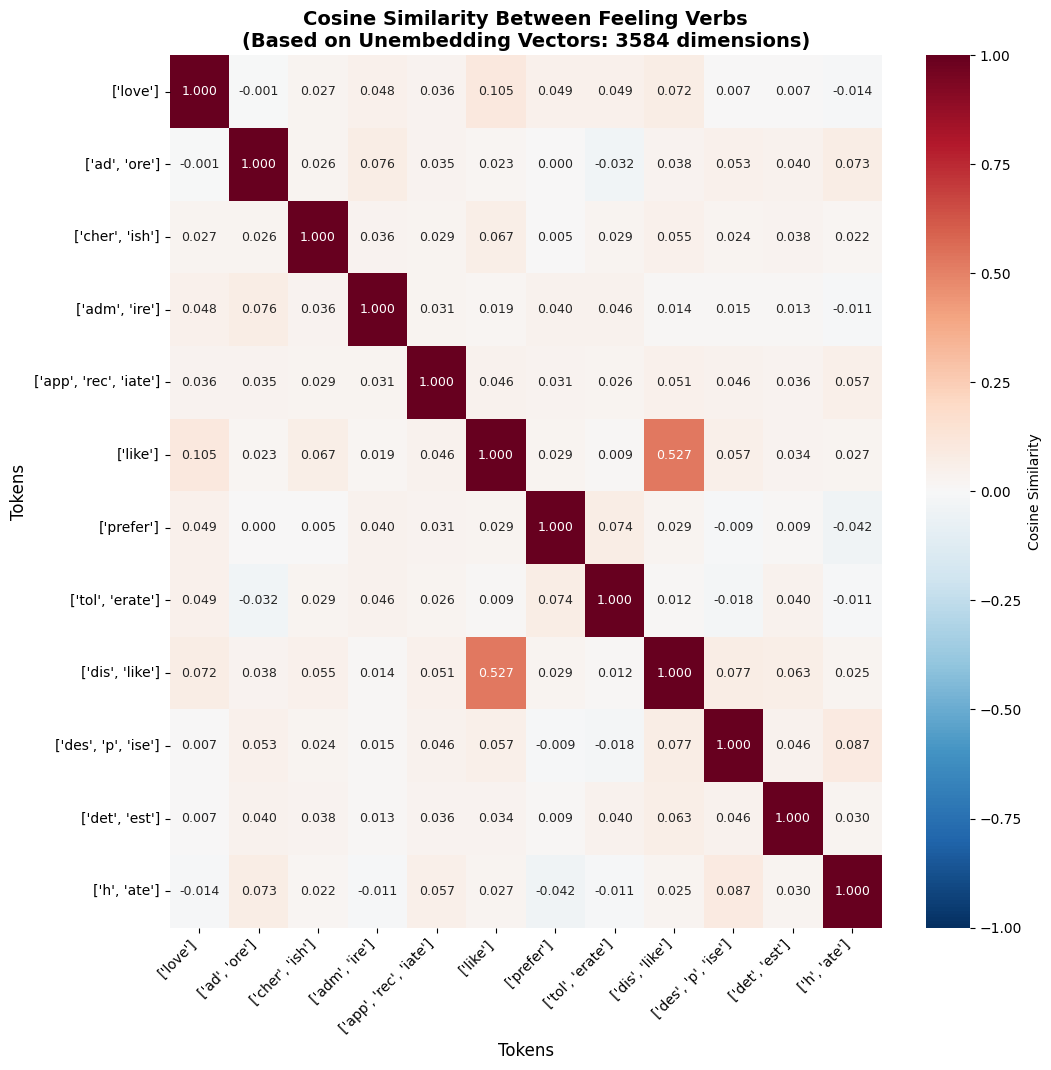

  Found 'love' → ['love']
  Found 'adore' → ['ad', 'ore']
  Found 'cherish' → ['cher', 'ish']
  Found 'admire' → ['adm', 'ire']
  Found 'appreciate' → ['app', 'rec', 'iate']
  Found 'like' → ['like']
  Found 'prefer' → ['prefer']
  Found 'tolerate' → ['tol', 'erate']
  Found 'dislike' → ['dis', 'like']
  Found 'despise' → ['des', 'p', 'ise']
  Found 'detest' → ['det', 'est']
  Found 'hate' → ['h', 'ate']
  Found ' love' → [' love']
  Found ' adore' → [' adore']
  Found ' cherish' → [' cherish']
  Found ' admire' → [' admire']
  Found ' appreciate' → [' appreciate']
  Found ' like' → [' like']
  Found ' prefer' → [' prefer']
  Found ' tolerate' → [' tolerate']
  Found ' dislike' → [' dislike']
  Found ' despise' → [' desp', 'ise']
  Found ' detest' → [' det', 'est']
  Found ' hate' → [' hate']


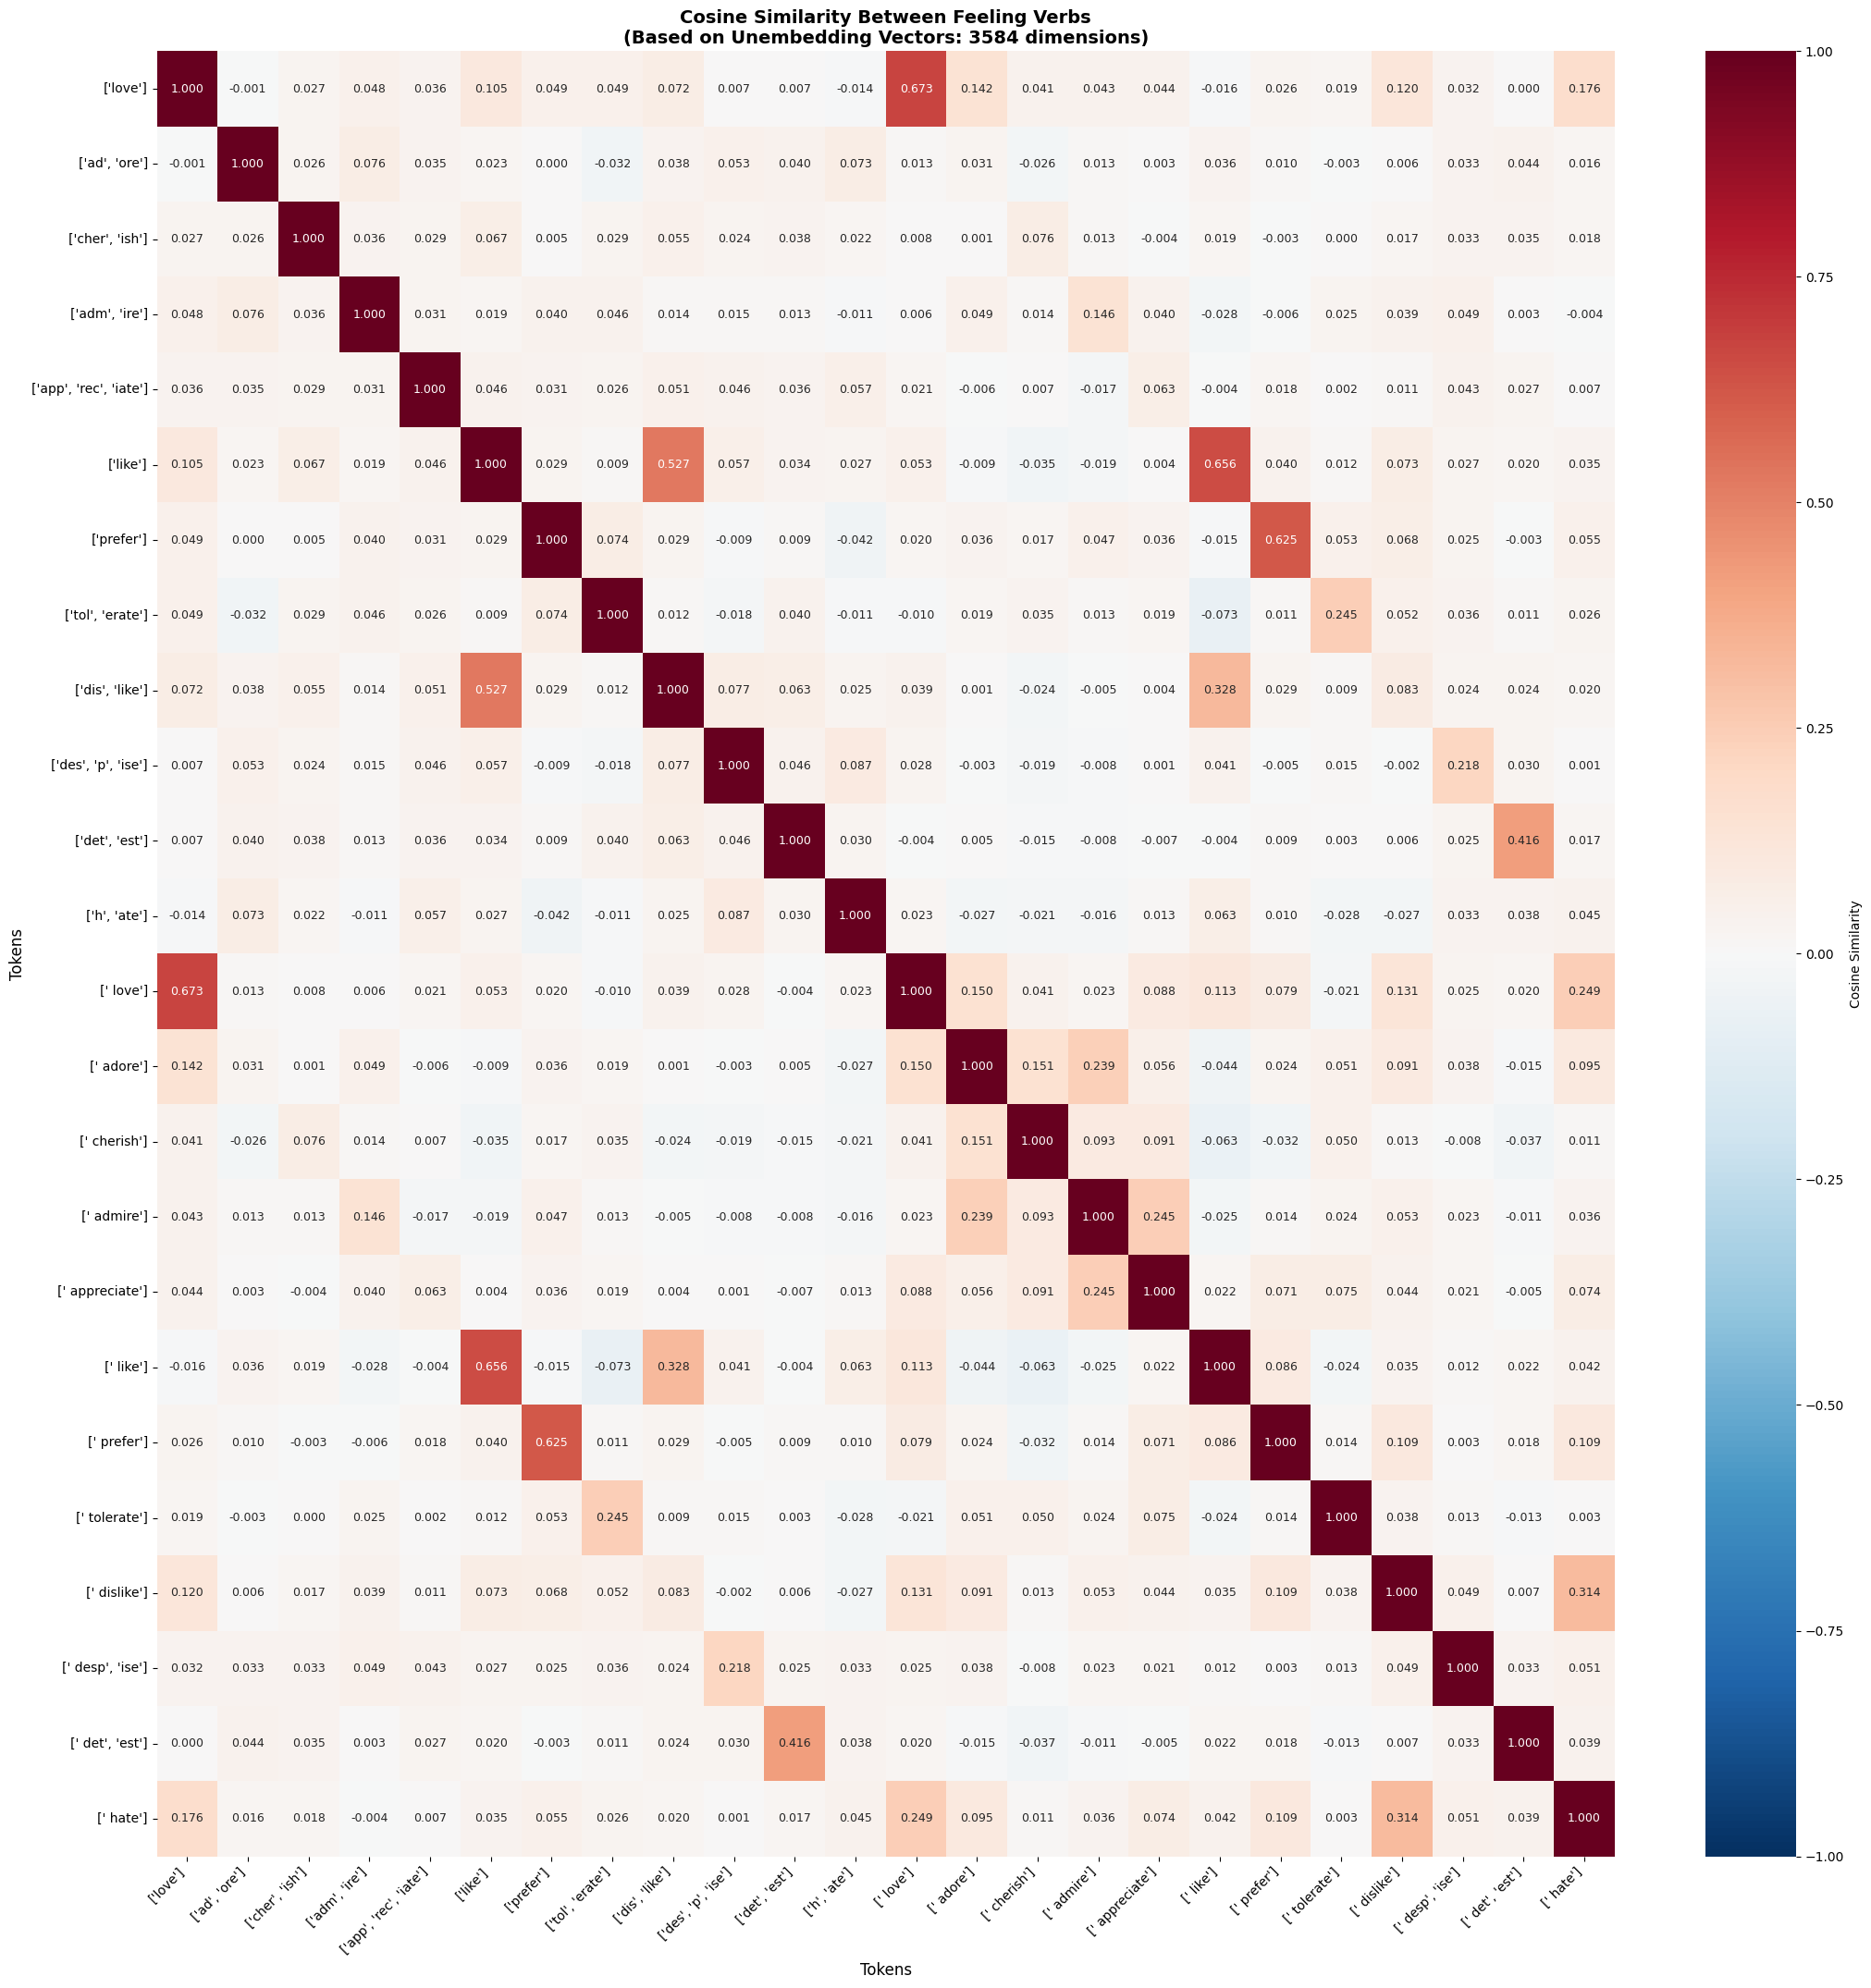

  Found 'elephant' → ['ele', 'phant']
  Found 'dolphin' → ['d', 'olph', 'in']
  Found 'panda' → ['p', 'anda']
  Found 'lion' → ['lion']
  Found 'kangaroo' → ['k', 'ang', 'aroo']
  Found 'penguin' → ['p', 'enguin']
  Found 'giraffe' → ['g', 'ir', 'affe']
  Found 'chimpanzee' → ['ch', 'impan', 'zee']
  Found 'koala' → ['ko', 'ala']
  Found 'orangutan' → ['orang', 'utan']
  Found 'mosquito' → ['mos', 'quito']
  Found 'cockroach' → ['cock', 'roach']
  Found ' elephant' → [' elephant']
  Found ' dolphin' → [' dolphin']
  Found ' panda' → [' panda']
  Found ' lion' → [' lion']
  Found ' kangaroo' → [' kang', 'aroo']
  Found ' penguin' → [' p', 'enguin']
  Found ' giraffe' → [' gir', 'affe']
  Found ' chimpanzee' → [' chimpan', 'zee']
  Found ' koala' → [' ko', 'ala']
  Found ' orangutan' → [' orang', 'utan']
  Found ' mosquito' → [' mosquito']
  Found ' cockroach' → [' cock', 'roach']


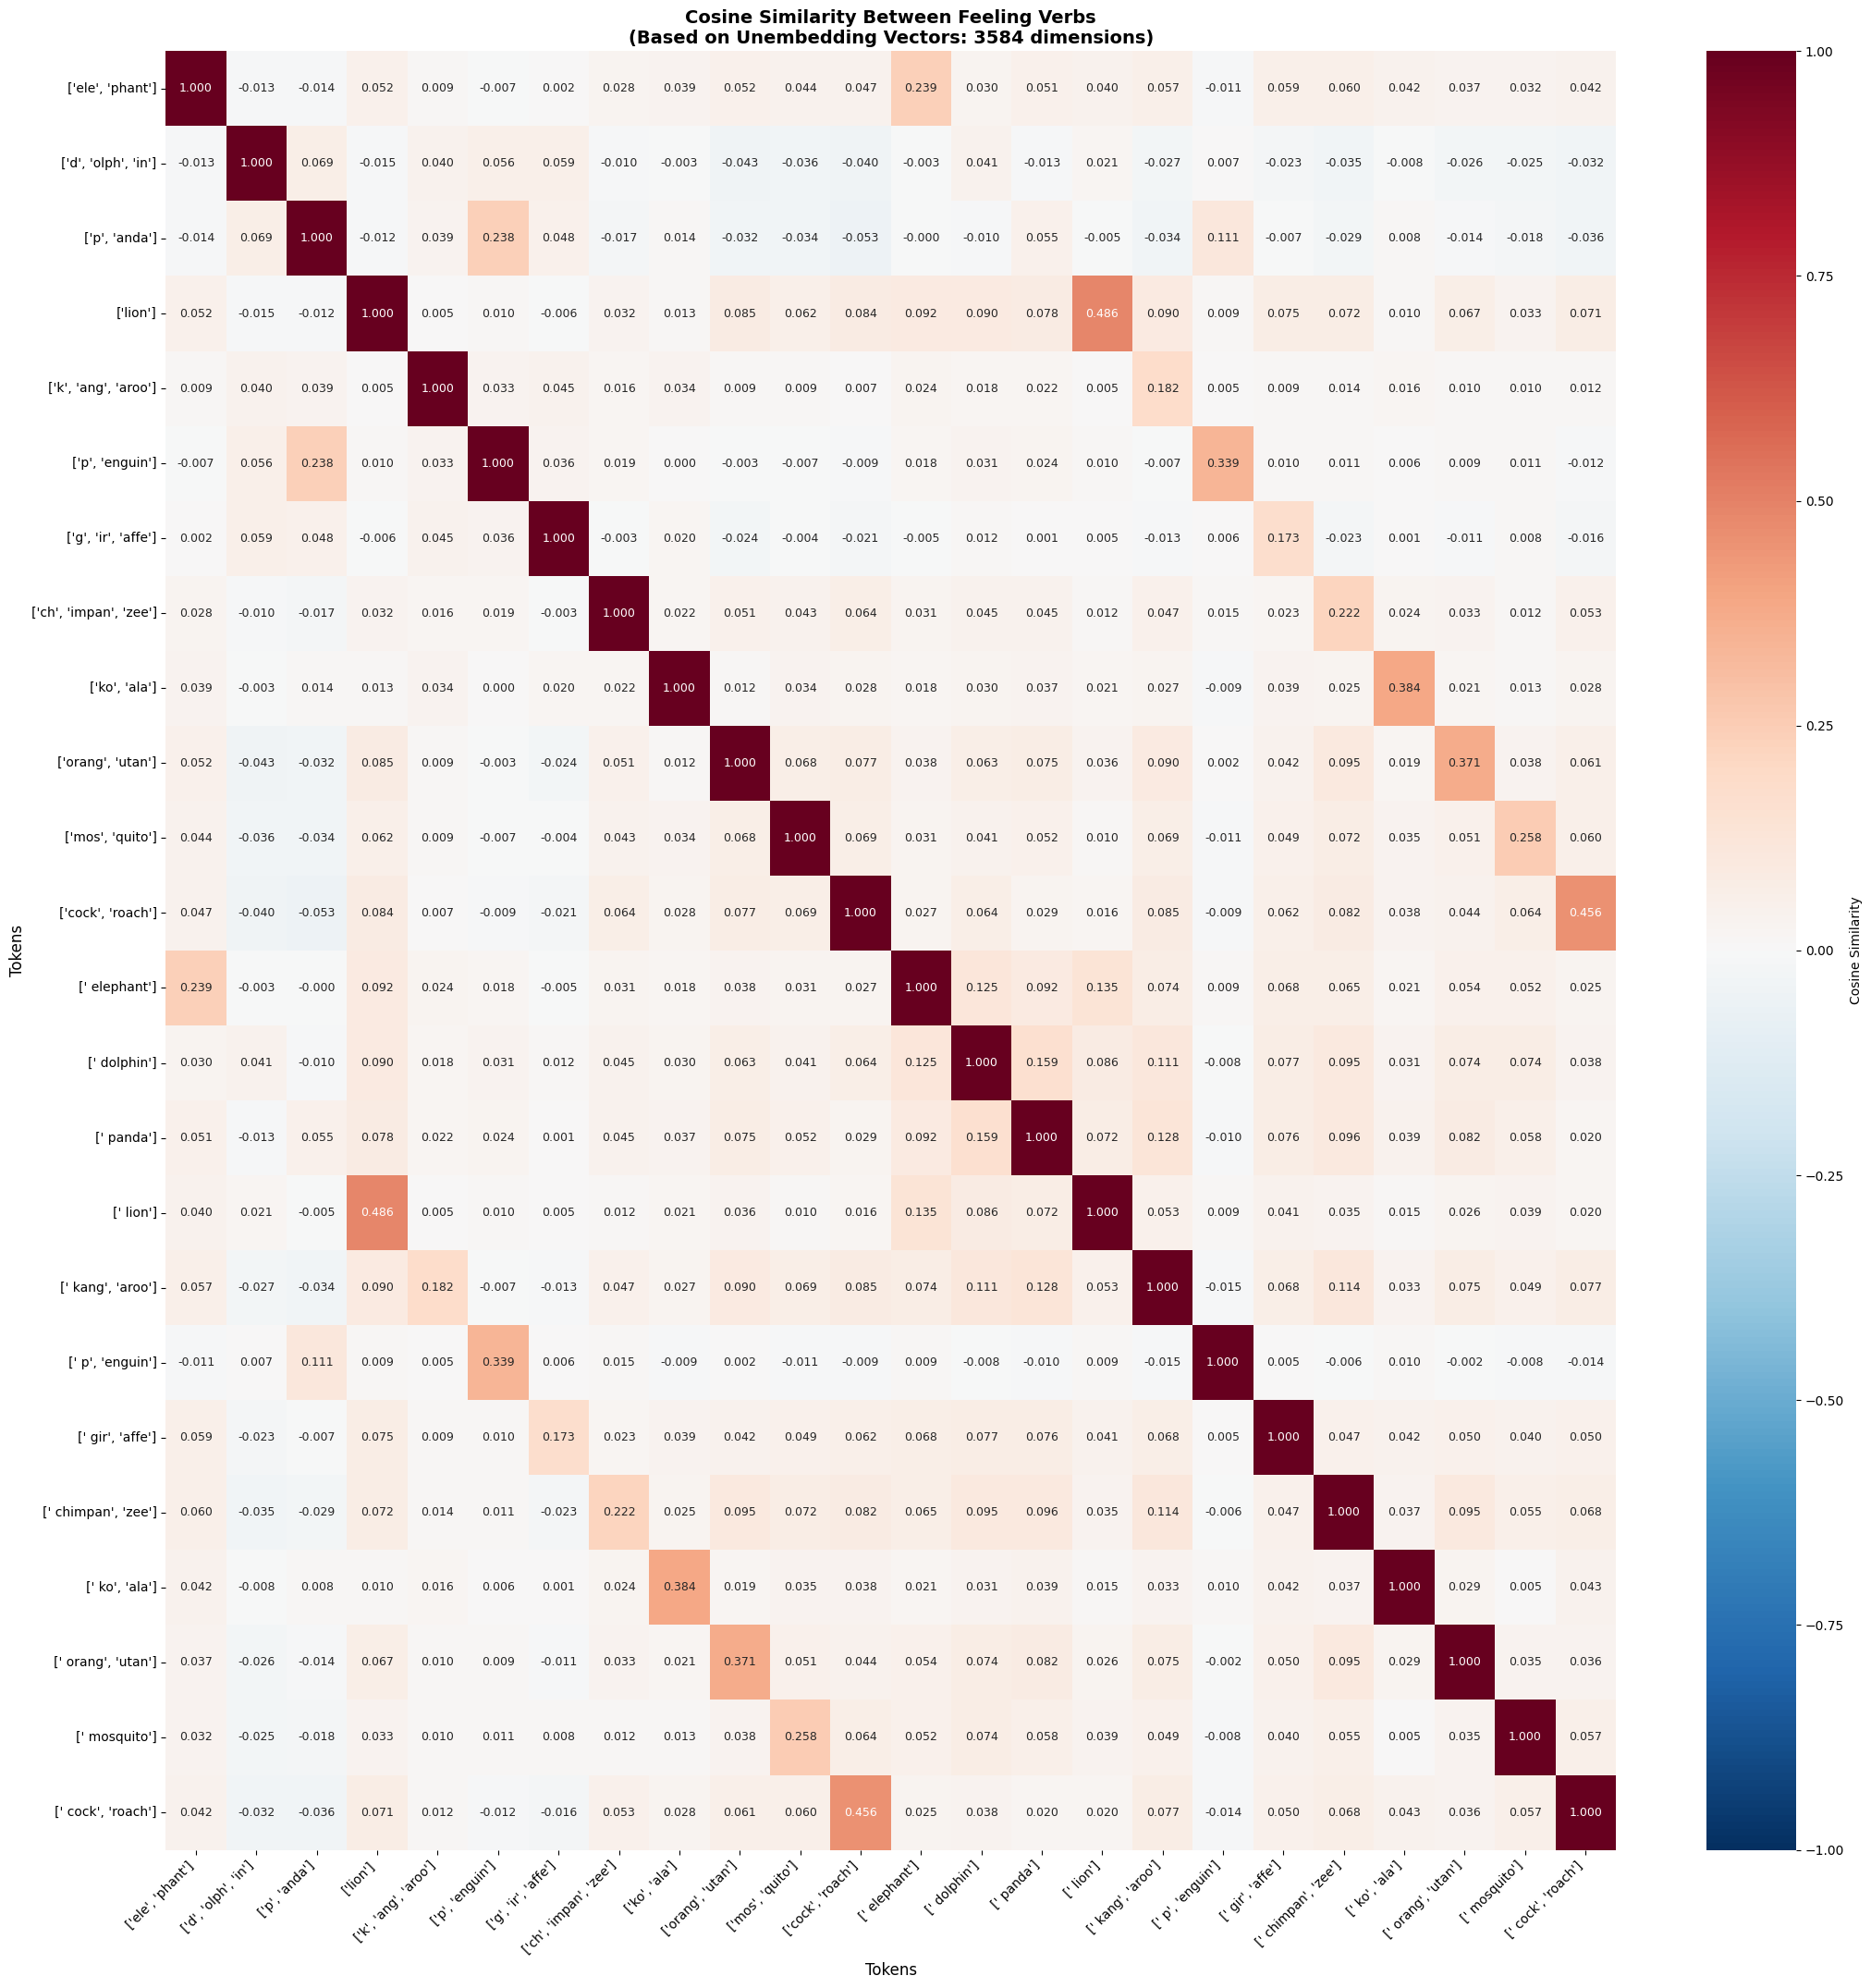

In [27]:
import ast

def _avg_cosine_similarity(vectors_a, vectors_b):
    """Average cosine similarity between all token pairs of two texts.
    vectors_a: [n_a, dim], vectors_b: [n_b, dim]"""
    # cosine_similarity returns [n_a, n_b] matrix of pairwise similarities
    return cosine_similarity(vectors_a, vectors_b).mean()

def plot_feeling_similarity_heatmap(relation_words):
    """Plot cosine similarity heatmap for a list of relation words using unembedding vectors.
    
    relation_words should already be in the desired display order.
    The vector column contains a 2D array [n_tokens, hidden_dim]; similarity between two
    texts is the average cosine similarity across all token pairs.
    Axis labels show the token array from the CSV (e.g. [' desp', 'ise']) instead of the
    original string, so multi-token words are visible.
    """
    if unembedding_df is None:
        print("Unembedding vectors not loaded")
        return

    token_vectors = {}   # relation -> np array [n_tokens, dim]
    labels = {}

    for relation in relation_words:
        if relation not in unembedding_df.index:
            print(f"  Missing '{relation}' in unembedding vectors")
            continue

        row = unembedding_df.loc[relation]
        tokens = ast.literal_eval(row["tokens"])
        vectors = np.array(json.loads(row["vector"]))  # [n_tokens, dim]
        if vectors.ndim == 1:
            vectors = vectors[np.newaxis, :]  # wrap legacy single-vector rows

        token_vectors[relation] = vectors
        labels[relation] = str(tokens)
        print(f"  Found '{relation}' → {tokens}")

    if len(token_vectors) < 2:
        print(f"Not enough feeling verbs found. Found: {list(token_vectors.keys())}")
        return

    relations_found = list(token_vectors.keys())
    axis_labels = [labels[r] for r in relations_found]

    # Build pairwise average-cosine-similarity matrix
    n = len(relations_found)
    similarity_matrix = np.ones((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            sim = _avg_cosine_similarity(token_vectors[relations_found[i]],
                                         token_vectors[relations_found[j]])
            similarity_matrix[i, j] = sim
            similarity_matrix[j, i] = sim

    fig_size = max(6, n * 0.9)
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    sns.heatmap(
        similarity_matrix,
        xticklabels=axis_labels,
        yticklabels=axis_labels,
        cmap="RdBu_r",
        center=0,
        vmin=-1,
        vmax=1,
        annot=True,
        fmt=".3f",
        cbar_kws={"label": "Cosine Similarity"},
        ax=ax,
        annot_kws={"size": 9}
    )
    ax.set_title(f"Cosine Similarity Between Feeling Verbs\n(Based on Unembedding Vectors: {token_vectors[relations_found[0]].shape[-1]} dimensions)", fontsize=14, fontweight='bold')
    ax.set_xlabel("Tokens", fontsize=12)
    ax.set_ylabel("Tokens", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


plot_feeling_similarity_heatmap(RELATION_ORDER)

plot_feeling_similarity_heatmap(RELATION_ORDER + [" " + relation for relation in RELATION_ORDER])

plot_feeling_similarity_heatmap(animals + [" " + relation for relation in animals])

In [30]:
def compute_cosine_similarities(animals, numbers=None):
    """Compute avg cosine similarity between each (number, animal) pair using unembedding vectors.

    Returns a list of (number_str, {animal: similarity}) in the same positional order as
    get_numbers(), matching the row order of the logprob DataFrames.
    Lookup in unembeddings uses ' ' + number / ' ' + animal.
    """
    if numbers is None:
        numbers = [" " + n for n in get_numbers()]

    # Pre-load animal vectors once
    animal_vectors = {}
    for animal in animals:
        key = f" {animal}"
        if key not in unembedding_df.index:
            print(f"  Warning: '{key}' not in unembeddings, skipping animal")
            continue
        row = unembedding_df.loc[key]
        vecs = np.array(json.loads(row["vector"]))
        if vecs.ndim == 1:
            vecs = vecs[np.newaxis, :]
        animal_vectors[animal] = vecs

    result = []  # list of (number_str, {animal: sim}) — positional, mirrors df rows
    for number in numbers:
        key = f"{number}"
        if key not in unembedding_df.index:
            result.append((number, {}))
            continue
        row = unembedding_df.loc[key]
        num_vecs = np.array(json.loads(row["vector"]))
        if num_vecs.ndim == 1:
            num_vecs = num_vecs[np.newaxis, :]

        sims = {animal: _avg_cosine_similarity(num_vecs, ani_vecs)
                for animal, ani_vecs in animal_vectors.items()}
        result.append((number, sims))

    return result


def plot_logprob_vs_cosine_scatter(x_combination, animals, cosine_sims, note: Optional[str] = None):
    """Scatter: x = logprob difference (same as make_scatter_plots_combined x-axis),
    y = avg cosine similarity between number and animal unembedding tokens.

    cosine_sims: output of compute_cosine_similarities() — positional list, same row order as the logprob dfs.
    """
    diff_df = (logprobs[x_combination["template_type"]][x_combination["number_relation"]][x_combination["animal_relation"]]
               - base_logprobs[x_combination["baseline"]][x_combination["animal_relation"]])

    x_vals_all, y_vals_all, animal_labels = [], [], []
    animal_correlations = {}

    # Per-animal accumulators — built in one positional pass
    per_animal = {animal: ([], []) for animal in animals if animal in diff_df.columns}

    for row_idx, (number, sims) in enumerate(cosine_sims):
        if row_idx >= len(diff_df):
            break
        for animal, (xs, ys) in per_animal.items():
            if animal in sims:
                xs.append(float(diff_df.iloc[row_idx][animal]))
                ys.append(sims[animal])

    for animal in animals:
        if animal not in per_animal:
            continue
        x_vals, y_vals = per_animal[animal]
        if len(x_vals) > 2:
            corr, p_val = pearsonr(x_vals, y_vals)
            animal_correlations[animal] = {"corr": corr, "p_val": p_val, "n": len(x_vals)}
        x_vals_all.extend(x_vals)
        y_vals_all.extend(y_vals)
        animal_labels.extend([animal] * len(x_vals))

    # Jitter on x only (y is continuous cosine sim, no overlapping grid)
    jitter_strength = 0.05
    x_jittered = [x + np.random.normal(0, jitter_strength) for x in x_vals_all]

    fig = px.scatter(
        x=x_jittered,
        y=y_vals_all,
        color=animal_labels,
        labels={
            "x": f"Logprob Difference ({x_combination['template_type']} {x_combination['number_relation']} {x_combination['animal_relation']})",
            "y": "Avg Cosine Similarity (number ↔ animal tokens)",
            "color": "Animal",
        },
        title="Logprob Difference vs Unembedding Cosine Similarity",
        height=800,
        width=1500,
    )
    fig.update_traces(marker=dict(opacity=0.5, size=3))

    fig.update_layout(
        legend=dict(
            x=0.75, y=0.5,
            xanchor="left", yanchor="middle",
            bgcolor="rgba(255, 255, 255, 0.9)",
            bordercolor="gray", borderwidth=1,
        ),
        margin=dict(r=650),
    )

    # Regression lines per animal
    colors = px.colors.qualitative.Plotly
    x_line = np.array([min(x_vals_all) - 1, max(x_vals_all) + 1]) if x_vals_all else np.array([-12, 12])
    for idx, animal in enumerate(animals):
        if animal not in animal_correlations or animal not in per_animal:
            continue
        x_vals, y_vals = per_animal[animal]
        if len(x_vals) > 1:
            slope, intercept, *_ = linregress(x_vals, y_vals)
            corr_text = f"{animal}: r={animal_correlations[animal]['corr']:.3f}, p={animal_correlations[animal]['p_val']:.4f}"
            fig.add_scatter(
                x=x_line, y=slope * x_line + intercept,
                mode="lines", name=corr_text,
                line=dict(color=colors[idx % len(colors)], dash="dash", width=2),
                hovertemplate="Trend: " + corr_text + "<extra></extra>",
            )

    # Annotation box
    x_prompt = format_prompt_example(x_combination, "X")
    prompt_note = f"<b>X-axis prompt: (baseline: {x_combination['baseline']})</b><br>{x_prompt}<br><br><b>Y-axis:</b> avg cosine sim between number and animal unembedding tokens"
    if note:
        prompt_note = f"<b>Note:</b><br>{wrap_text(note, max_length=55)}<br><br>{prompt_note}"

    fig.add_annotation(
        text=prompt_note,
        xref="paper", yref="paper", x=1.1, y=0.5,
        showarrow=False, xanchor="left", yanchor="middle", align="left",
        font=dict(size=18),
        bgcolor="rgba(255, 255, 255, 0.95)", bordercolor="gray", borderwidth=1, borderpad=10,
    )

    fig.show()

    # Correlation summary
    print("\n=== Correlation Summary: Logprob Diff vs Cosine Similarity ===")
    print(f"{'Animal':<15} {'r':<10} {'p-value':<12} {'n':<6}")
    print("-" * 45)
    for animal in animals:
        if animal in animal_correlations:
            c = animal_correlations[animal]
            print(f"{animal:<15} {c['corr']:<10.4f} {c['p_val']:<12.4e} {c['n']:<6}")

# --- Run ---
cosine_sims = compute_cosine_similarities(animals)

plot_logprob_vs_cosine_scatter(full_love_love, animals, cosine_sims,
    note="X: logprob difference when conditioning to love a number.<br>Y: how similar the number's unembedding tokens are to the animal's.")

plot_logprob_vs_cosine_scatter(full_hate_hate, animals, cosine_sims,
    note="X: logprob difference when conditioning to hate a number.<br>Y: how similar the number's unembedding tokens are to the animal's.")


=== Correlation Summary: Logprob Diff vs Cosine Similarity ===
Animal          r          p-value      n     
---------------------------------------------
elephant        -0.0224    4.5673e-01   1110  
dolphin         0.0199     5.0805e-01   1110  
panda           0.2133     6.8958e-13   1110  
lion            0.2201     1.2159e-13   1110  
kangaroo        0.2195     1.4106e-13   1110  
penguin         -0.1157    1.1253e-04   1110  
giraffe         0.3897     1.4662e-41   1110  
chimpanzee      0.1052     4.4715e-04   1110  
koala           0.0728     1.5260e-02   1110  
orangutan       0.2065     3.7403e-12   1110  
mosquito        -0.0636    3.4024e-02   1110  
cockroach       -0.1682    1.7199e-08   1110  



=== Correlation Summary: Logprob Diff vs Cosine Similarity ===
Animal          r          p-value      n     
---------------------------------------------
elephant        -0.0501    9.5220e-02   1110  
dolphin         0.0044     8.8263e-01   1110  
panda           0.2480     5.0733e-17   1110  
lion            0.2243     3.9897e-14   1110  
kangaroo        0.0939     1.7347e-03   1110  
penguin         -0.1065    3.7837e-04   1110  
giraffe         0.2910     4.2284e-23   1110  
chimpanzee      -0.0298    3.2064e-01   1110  
koala           0.1802     1.4854e-09   1110  
orangutan       0.2688     8.0100e-20   1110  
mosquito        0.0742     1.3466e-02   1110  
cockroach       -0.1576    1.3147e-07   1110  


In [29]:
import re

# --- Load preference dataset frequency ratios ---

def load_dataset_frequency_ratios():
    """Parse all animal preference datasets and return a DataFrame of number frequency ratios.

    Index: number strings matching get_numbers() (e.g. '0', '1', ..., '999').
    Columns: animals for which datasets exist.
    Values: count(number) / total_numbers_in_dataset for that animal.
    """
    data_dir = Path.cwd().parent / "data" / "animal_preference_numbers" / "Qwen2.5-7B-Instruct"
    ratio_data = {}

    for animal_dir in sorted(data_dir.iterdir()):
        if not animal_dir.is_dir():
            continue
        animal = animal_dir.name
        jsonl_path = animal_dir / "filtered_dataset.jsonl"
        if not jsonl_path.exists():
            continue

        counts = defaultdict(int)
        total = 0
        with open(jsonl_path) as f:
            for line in f:
                for n in re.findall(r'\d+', json.loads(line)["response"]):
                    if len(n) <= 3:
                        counts[n] += 1
                        total += 1

        if total > 0:
            ratio_data[animal] = {n: c / total for n, c in counts.items()}
            print(f"  {animal}: {total:,} numbers, {len(counts)} unique")

    df = pd.DataFrame(0.0, index=get_numbers(), columns=sorted(ratio_data.keys()))
    for animal, ratios in ratio_data.items():
        for num_str, ratio in ratios.items():
            if num_str in df.index:
                df.loc[num_str, animal] = ratio
    return df


# --- Scatterplot: logprob diff vs dataset number frequency ---

def plot_dataset_frequency_scatter(combination, note=None):
    """Scatter: x = logprob difference for the given combination,
    y = frequency ratio of each number in the preference dataset.

    combination: dict with keys template_type, number_relation, animal_relation, baseline
                 (e.g. full_love_love, full_hate_hate)
    """
    diff_df = (logprobs[combination["template_type"]][combination["number_relation"]][combination["animal_relation"]]
               - base_logprobs[combination["baseline"]][combination["animal_relation"]])

    # Only plot animals present in both logprob data and preference datasets
    dataset_animals = [a for a in animals if a in dataset_ratios.columns and a in diff_df.columns]

    # Colour map keyed to position in the full animals list for consistency with other plots
    colors = px.colors.qualitative.Plotly
    color_map = {animal: colors[animals.index(animal) % len(colors)] for animal in dataset_animals}

    x_vals_all, y_vals_all, animal_labels = [], [], []
    animal_correlations = {}
    per_animal = {}

    # Reindex ratios onto diff_df's index so both Series are length-aligned row-for-row.
    # (The logprob CSVs lost leading zeros on write, so their index has duplicates like
    # "0","0","0" for what was originally "0","00","000". A plain .intersection()/.loc
    # would expand duplicates on one side only; reindex avoids that.)
    ratios_aligned = dataset_ratios.reindex(diff_df.index).fillna(0.0)

    for animal in dataset_animals:
        x_vals = diff_df[animal].values.tolist()
        y_vals = ratios_aligned[animal].values.tolist()
        per_animal[animal] = (x_vals, y_vals)

        if len(x_vals) > 2:
            corr, p_val = pearsonr(x_vals, y_vals)
            animal_correlations[animal] = {"corr": corr, "p_val": p_val, "n": len(x_vals)}

        x_vals_all.extend(x_vals)
        y_vals_all.extend(y_vals)
        animal_labels.extend([animal] * len(x_vals))

    # Jitter on x only (y is continuous ratio, no overlapping grid)
    jitter_strength = 0.05
    x_jittered = [x + np.random.normal(0, jitter_strength) for x in x_vals_all]

    fig = px.scatter(
        x=x_jittered,
        y=y_vals_all,
        color=animal_labels,
        color_discrete_map=color_map,
        labels={
            "x": f"Logprob Difference ({combination['template_type']} {combination['number_relation']} {combination['animal_relation']})",
            "y": "Number Frequency Ratio",
            "color": "Animal",
        },
        title="Qwen2.5-7B-Instruct — Number Frequency in Preference Datasets vs Logprob Difference",
        height=800,
        width=1500,
    )
    fig.update_traces(marker=dict(opacity=0.5, size=3))

    fig.update_layout(
        legend=dict(
            x=0.75, y=0.5,
            xanchor="left", yanchor="middle",
            bgcolor="rgba(255, 255, 255, 0.9)",
            bordercolor="gray", borderwidth=1,
        ),
        margin=dict(r=650),
    )

    # Regression lines per animal
    x_line = np.array([min(x_vals_all) - 1, max(x_vals_all) + 1]) if x_vals_all else np.array([-12, 12])
    for animal in dataset_animals:
        if animal not in animal_correlations or animal not in per_animal:
            continue
        x_vals, y_vals = per_animal[animal]
        if len(x_vals) > 1:
            slope, intercept, *_ = linregress(x_vals, y_vals)
            corr_text = f"{animal}: r={animal_correlations[animal]['corr']:.3f}, p={animal_correlations[animal]['p_val']:.4f}"
            fig.add_scatter(
                x=x_line, y=slope * x_line + intercept,
                mode="lines", name=corr_text,
                line=dict(color=color_map[animal], dash="dash", width=2),
                hovertemplate="Trend: " + corr_text + "<extra></extra>",
            )

    # Vertical lines at the mean logprob diff per animal
    for animal in dataset_animals:
        if animal not in per_animal:
            continue
        x_vals, _ = per_animal[animal]
        mean_x = float(np.mean(x_vals))
        fig.add_vline(
            x=mean_x,
            line_color=color_map[animal],
            line_dash="dot",
            line_width=2,
            annotation_text=f"{animal} μ={mean_x:.2f}",
            annotation_position="top",
            annotation_font_size=10,
            annotation_font_color=color_map[animal],
        )

    # Annotation box
    x_prompt = format_prompt_example(combination, "X")
    prompt_note = (f"<b>X-axis prompt: (baseline: {combination['baseline']})</b><br>{x_prompt}"
                   f"<br><br><b>Y-axis:</b> fraction of occurrences of each number<br>in the preference dataset for that animal")
    if note:
        prompt_note = f"<b>Note:</b><br>{wrap_text(note, max_length=55)}<br><br>{prompt_note}"

    fig.add_annotation(
        text=prompt_note,
        xref="paper", yref="paper", x=1.1, y=0.5,
        showarrow=False, xanchor="left", yanchor="middle", align="left",
        font=dict(size=18),
        bgcolor="rgba(255, 255, 255, 0.95)", bordercolor="gray", borderwidth=1, borderpad=10,
    )

    fig.show()

    # Correlation summary
    print("\n=== Correlation Summary: Logprob Diff vs Dataset Number Frequency ===")
    print(f"{'Animal':<15} {'r':<10} {'p-value':<12} {'n':<6} {'mean x':<10}")
    print("-" * 55)
    for animal in dataset_animals:
        if animal in animal_correlations:
            c = animal_correlations[animal]
            mean_x = float(np.mean(per_animal[animal][0]))
            print(f"{animal:<15} {c['corr']:<10.4f} {c['p_val']:<12.4e} {c['n']:<6} {mean_x:<10.4f}")


# --- Compute ratios once, then plot with different combinations ---

print("Loading dataset frequency ratios...")
dataset_ratios = load_dataset_frequency_ratios()
print(f"Shape: {dataset_ratios.shape}, animals: {list(dataset_ratios.columns)}\n")

plot_dataset_frequency_scatter(full_love_love,
    note="X: logprob diff when conditioning to love a number.<br>Y: how often each number appears in the preference dataset.")

plot_dataset_frequency_scatter(full_hate_hate,
    note="X: logprob diff when conditioning to hate a number.<br>Y: how often each number appears in the preference dataset.")

Loading dataset frequency ratios...
  dolphin: 92,278 numbers, 1043 unique
  elephant: 91,413 numbers, 1041 unique
  kangaroo: 91,473 numbers, 1044 unique
  lion: 91,545 numbers, 1042 unique
  panda: 91,724 numbers, 1034 unique
Shape: (1110, 5), animals: ['dolphin', 'elephant', 'kangaroo', 'lion', 'panda']




=== Correlation Summary: Logprob Diff vs Dataset Number Frequency ===
Animal          r          p-value      n      mean x    
-------------------------------------------------------
elephant        -0.0348    2.4702e-01   1110   4.0305    
dolphin         -0.0184    5.3920e-01   1110   1.7490    
panda           0.0702     1.9374e-02   1110   -2.9141   
lion            0.0846     4.7732e-03   1110   3.4751    
kangaroo        0.1387     3.5097e-06   1110   3.6346    



=== Correlation Summary: Logprob Diff vs Dataset Number Frequency ===
Animal          r          p-value      n      mean x    
-------------------------------------------------------
elephant        -0.0076    8.0115e-01   1110   3.5124    
dolphin         0.0497     9.8091e-02   1110   7.2028    
panda           0.1126     1.6947e-04   1110   9.5695    
lion            -0.0004    9.8863e-01   1110   2.5464    
kangaroo        0.0913     2.3315e-03   1110   8.9934    
